# Tracking a 1d pendulum using continuous-discrete Extended / Unscented / Ensemble Kalman filter

This notebook demonstrates a simple pendulum tracking example where underlying dynamics are continuous and data are sampled discretely at irregular intervals. To cope with this, we apply continuous-discrete filtering algorithms (EKF, UKF, EnKF).

The example is taken from p45 of 
*Bayesian Filtering and Smoothing* (S. Särkkä, 2013).
This code is based on the  [sarkka-jax](https://github.com/petergchang/sarkka-jax) repo.


The physics of the problem is shown below, where $\alpha$ is the angle relative to vertical,
and $w(t)$ is a white noise process added to the angular velocity (a random acceleration term).

![Pendulum](https://github.com/probml/dynamax/blob/main/docs/figures/pendulum.png?raw=true)

This gives rise to the following differential equation:
\begin{align*}
\frac{d^2 \alpha}{d t^2}
= -g \sin(\alpha) + w(t)
\end{align*}
We can write this as a nonlinear SSM by defining the state to be
$z_1(t) = \alpha(t)$ and $z_2(t) = d\alpha(t)/dt$.
Thus

\begin{align*}
\frac{d z}{dt}
= \begin{pmatrix} z_2 \\ -g \sin(z_1) \end{pmatrix}
+ \begin{pmatrix} 0 \\ 1 \end{pmatrix} w(t)
\end{align*}

We numerically approximate random path solutions to this SDE using Heun's method (i.e. improved Euler), as implemented in [Diffrax](https://docs.kidger.site/diffrax/api/solvers/sde_solvers/).






We assume the observation model is

\begin{align*}
y_t &= h(z_t) + r_t \\
h(z_t) &=  \sin(\alpha_t)  = \sin(z_{t,1}) \\
r_t &\sim N(0,R)
\end{align*}


## Setup

In [37]:
%%capture
try:
    import dynamax
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -q dynamax[notebooks]
    import dynamax

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from jax import lax
from jaxtyping import Float, Array
from typing import Callable, NamedTuple

# For pretty print of ndarrays
jnp.set_printoptions(formatter={"float_kind": "{:.2f}".format})

In [39]:
# import discrete-time filters
from dynamax.nonlinear_gaussian_ssm import ParamsNLGSSM, UKFHyperParams
from dynamax.nonlinear_gaussian_ssm import extended_kalman_smoother, unscented_kalman_smoother

In [40]:
# import continuous-discrete nonlinear Gaussian SSM code
import sys
sys.path.append("..")
sys.path.append("../src")
# use custom src codebase
from utils.plotting import *
from continuous_discrete_nonlinear_gaussian_ssm import ContDiscreteNonlinearGaussianSSM
from continuous_discrete_nonlinear_gaussian_ssm import cdnlgssm_filter
from continuous_discrete_nonlinear_gaussian_ssm import EnKFHyperParams, EKFHyperParams, UKFHyperParams


In [41]:
# Some parameters
dt = 0.0125
g = 9.8
q_c = 1
r = 0.3

def dynamics_drift_function(x, t):
    return jnp.array([x[1], - g * jnp.sin(x[0])])

def emission_function(x):
    return jnp.array([jnp.sin(x[0])])

# Diffusion coefficient
L = jnp.array([[0, 0], [0, 1]])

Text(0.5, 1.0, 'Training Emissions')

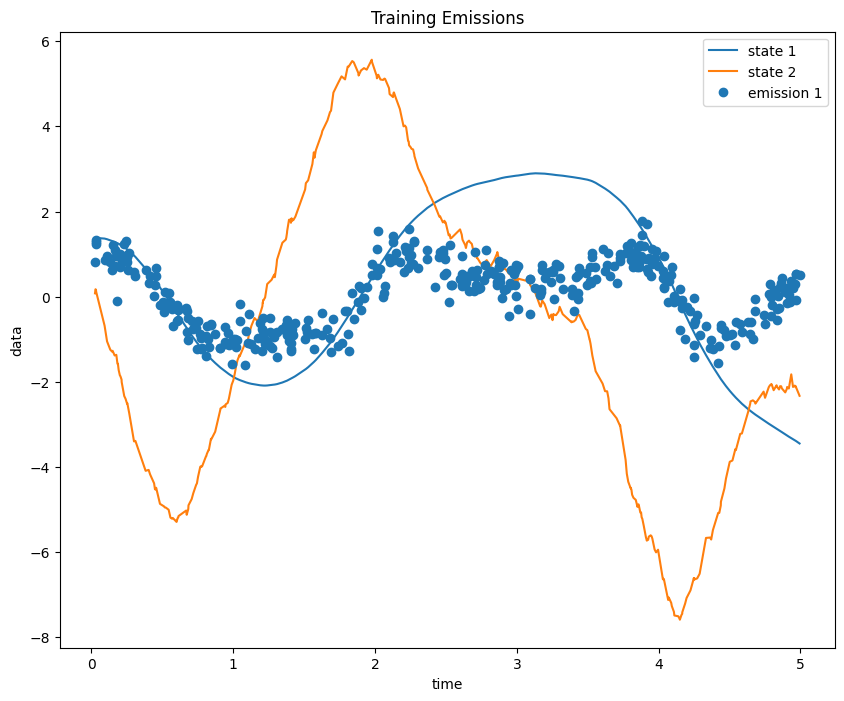

In [42]:
state_dim = 2
emission_dim = 1
num_timesteps = 400
key = jr.PRNGKey(0)

# set timesteps to be 400 timesteps at dt intervals
# t_emissions = jnp.arange(num_timesteps) * dt
# t_emissions = t_emissions.reshape(-1, 1)
T = 5.0
t_emissions = jnp.array(sorted(jr.uniform(jr.PRNGKey(0), (num_timesteps, 1), minval=0, maxval=T)))

# set up drift function
from continuous_discrete_nonlinear_gaussian_ssm.models import (
    LearnableFunction,
    ConstantLearnableFunction,
    LinearLearnableFunction,
)

class CustomDrift(LearnableFunction):
    params: 0

    def f(self, x, u=None, t=None):
        return jnp.array([x[1], -g * jnp.sin(x[0])])

class CustomEmission(LearnableFunction):
    params: 0

    def f(self, x, u=None, t=None):
        return jnp.array([jnp.sin(x[0])])


learnable_drift = CustomDrift(params=0)
learnable_emission = CustomEmission(params=0)
learnable_diffusion_cov = ConstantLearnableFunction(params=jnp.eye(state_dim) * (q_c**2))
learnable_diffusion_coefficient = ConstantLearnableFunction(params=L)
learnable_emission_cov = ConstantLearnableFunction(params=jnp.eye(emission_dim) * (r**2))

true_model = ContDiscreteNonlinearGaussianSSM(state_dim, emission_dim)
key, key_root = jr.split(key)
true_params, param_props = true_model.initialize(
    key,
    initial_mean=jnp.array([jnp.pi / 2, 0]),
    initial_cov=jnp.eye(state_dim) * 0.2,
    dynamics_drift=learnable_drift,
    dynamics_diffusion_coefficient=learnable_diffusion_coefficient,
    dynamics_diffusion_cov=learnable_diffusion_cov,
    dynamics_approx_order=1.,
    emission_function=learnable_emission,
    emission_cov=learnable_emission_cov,
)

key, key_root = jr.split(key)
true_states, emissions = true_model.sample(true_params, key, num_timesteps, t_emissions)

# Plot the true states and emissions
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t_emissions, true_states[:, 0], color="C0", label="state 1")
ax.plot(t_emissions, true_states[:, 1], color="C1", label="state 2")
ax.plot(t_emissions, emissions[:, 0], 'o', color="C0", label="emission 1")
ax.legend()
ax.set_ylabel("data")
ax.set_xlabel("time")
ax.set_title("Training Emissions")

## Sample data and plot it

In [43]:

def plot_pendulum(time_grid, x_tr, x_obs, x_est=None, est_type=""):
    plt.figure()
    plt.plot(time_grid, x_tr, color="darkgray", linewidth=4, label="True Angle")
    plt.plot(time_grid, x_obs, "ok", fillstyle="none", ms=1.5, label="Measurements")
    if x_est is not None:
        plt.plot(time_grid, x_est, color="red", linewidth=1.5, label=f"{est_type} Estimate")
    plt.xlabel("Time $t$")
    plt.ylabel("Pendulum angle $x_{1,k}$")
    # plt.xlim(0, 5)
    # plt.ylim(-3, 5)
    # plt.xticks(jnp.arange(0.5, 4.6, 0.5))
    # plt.yticks(jnp.arange(-3, 5.1, 1))
    # plt.gca().set_aspect(0.5)
    plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor="k")
    plt.show()

In [44]:
# Compute RMSE
def compute_rmse(y, y_est):
    return jnp.sqrt(jnp.sum((y - y_est) ** 2) / len(y))


# Compute RMSE of estimate and print comparison with
# standard deviation of measurement noise
def compute_and_print_rmse_comparison(y, y_est, R, est_type=""):
    rmse_est = compute_rmse(y, y_est)
    print(f'{f"The RMSE of the {est_type} estimate is":<40}: {rmse_est:.2f}')
    print(f'{"The std of measurement noise is":<40}: {jnp.sqrt(R):.2f}')

In [45]:
# EnKF
enkf_filtered = cdnlgssm_filter(true_params, emissions, EnKFHyperParams(), t_emissions)

# EKF
ekf_filtered = cdnlgssm_filter(true_params, emissions, EKFHyperParams(), t_emissions)

# UKF
ukf_filtered = cdnlgssm_filter(true_params, emissions, UKFHyperParams(), t_emissions)

## Extended Kalman Filter

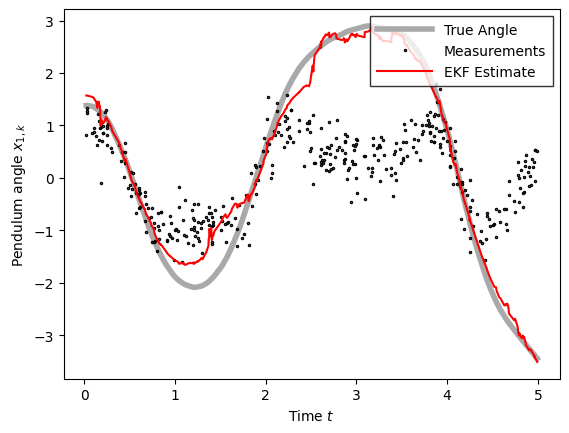

The RMSE of the EKF estimate is         : 0.29
The std of measurement noise is         : 0.55


In [46]:
m_ekf = ekf_filtered.filtered_means[:, 0]
plot_pendulum(t_emissions, true_states[:, 0], emissions, x_est=m_ekf, est_type="EKF")
compute_and_print_rmse_comparison(true_states[:, 0], m_ekf, r, "EKF")

## Ensemble Kalman Filter

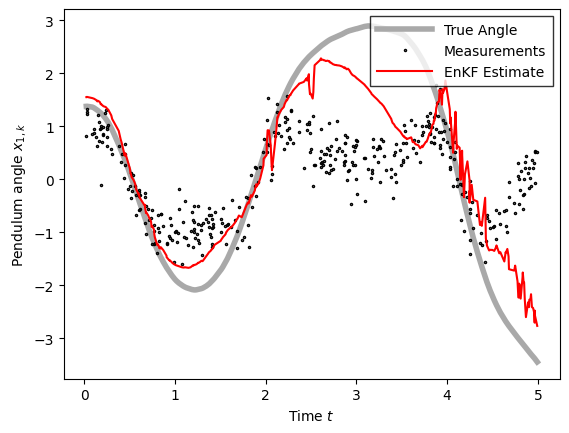

The RMSE of the EnKF estimate is        : 0.78
The std of measurement noise is         : 0.55


In [47]:
m_enkf = enkf_filtered.filtered_means[:, 0]
plot_pendulum(t_emissions, true_states[:, 0], emissions, x_est=m_enkf, est_type="EnKF")
compute_and_print_rmse_comparison(true_states[:, 0], m_enkf, r, "EnKF")

## Unscented Kalman Filter

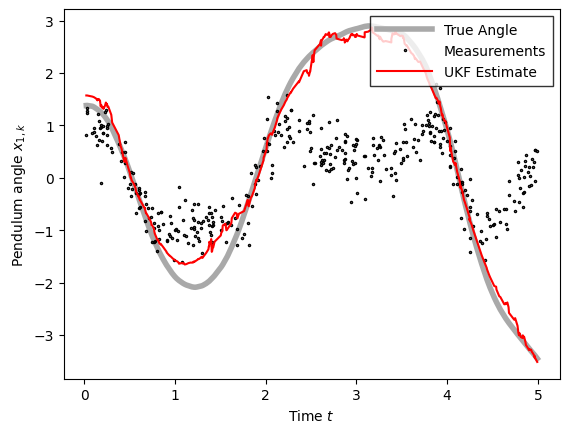

The RMSE of the UKF estimate is         : 0.24
The std of measurement noise is         : 0.55


In [48]:
m_ukf = ukf_filtered.filtered_means[:, 0]
plot_pendulum(t_emissions, true_states[:, 0], emissions, x_est=m_ukf, est_type="UKF")
compute_and_print_rmse_comparison(true_states[:, 0], m_ukf, r, "UKF")